In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mra 
import selector as se

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)

# Create parameters

In [3]:
rho = 1.
num_points = 10
eps_sublevel = percent = 0.1

alpha = 1 # proximal term coefficient

num_agents = num_packages = 200
num_fcs = 50
history = 3
res_type="primal"

filename = "local_ap_N%d_%.2f_n%d_m%d_H%d_%s"%(num_points, eps_sublevel, num_agents, num_fcs, history, res_type)

In [4]:
econ, A_ineq, b_ineq = mra.ap_data(num_packages, num_fcs)

In [5]:
b_norm = np.linalg.norm(b_ineq)

# CVXPY centralized solution

In [ ]:
true_xp, true_xf, true_f, true_lamb, true_prob = mra.assignment_problem_milp_solution(num_packages, num_fcs, econ,  integer=False)
print(f"{true_f=}")

true_f=-90.29596235198767


In [7]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

0.12754546028331876

In [8]:
true_lamb.shape, true_xp.size + true_xf.size

((50,), 10050)

In [9]:
fun_agents_eps = []
fun_agents_noisy_y = []

for i in range(num_packages):
    fun_agents_eps += [lambda lamb_k, K, i=i: mra.cvx_package_agent_query_multiple_actions(lamb_k, i, num_fcs,
                                                                                  econ, eps_sublevel=eps_sublevel, K=K,  return_best=True)]
    fun_agents_noisy_y += [lambda lamb_k, K, i=i: mra.cvx_package_agent_query_multiple_actions_noisy_prices(lamb_k, i, num_fcs,
                                                                                  econ, percent=percent, K=K,  return_best=True)]
 
for i in range(num_packages, num_packages+num_fcs):
    fun_agents_eps += [lambda lamb_k, K, i=i: mra.fc_agent_query_multiple_actions(lamb_k, i-num_packages, 
                                                                          econ, eps_sublevel=eps_sublevel, K=K, return_best=True)]
    fun_agents_noisy_y += [lambda lamb_k, K, i=i: mra.fc_agent_query_multiple_actions_noisy_prices(lamb_k, i-num_packages, 
                                                                          econ, percent=percent, K=K, return_best=True)]


fun_obj_val = lambda x_k: mra.assignment_problem_obj_val(x_k, num_packages, num_fcs, econ, integer=False)

# Localization

In [10]:
price_max = 3 * true_lamb.max()
price_min = (1./3) * true_lamb.min()
K_i = num_points
N = num_agents
primal_var_size = A_ineq.shape[1]

In [11]:
all_results_eps, lamb_k_eps, _, x_k, _, mra_xk_eps  = mra.price_localization_primal_recovery(fun_agents_eps, fun_obj_val, primal_var_size, A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=100, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type=res_type, history=history)


all_results_noisy_y, lamb_k_eps, _, x_k, _, mra_xk_noisy_y  = mra.price_localization_primal_recovery(fun_agents_noisy_y, fun_obj_val, primal_var_size, 
                                                                                                      A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=100, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type=res_type, history=history)

/Users/parshakova.tanya/Documents/projects/mra_precovery/mra/localization_prim_rec.py:85: RuntimeWarning: divide by zero encountered in scalar divide
  lamb_rel_diff = np.linalg.norm(lamb_k - lamb_prev) / np.linalg.norm(lamb_prev)


epoch=0, f_subopt_xk=1.3026E+00,  f_subopt_mra=1.2464E+00,  viol_xk=1.3706E+02, viol_mra=1.3050E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=9.5050E-03,  f_subopt_mra=4.9035E-02,  viol_xk=7.1921E+01, viol_mra=2.7741E-01, lamb_rel_diff=5.4798E-02
epoch=99, f_subopt_xk=2.3330E-03,  f_subopt_mra=4.6359E-02,  viol_xk=6.1311E+01, viol_mra=2.5860E-01, lamb_rel_diff=2.5192E-02
epoch=0, f_subopt_xk=1.3026E+00,  f_subopt_mra=1.3026E+00,  viol_xk=1.3706E+02, viol_mra=1.3706E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=9.5051E-03,  f_subopt_mra=1.2908E-02,  viol_xk=7.1921E+01, viol_mra=7.2102E-02, lamb_rel_diff=5.4798E-02
epoch=99, f_subopt_xk=2.3332E-03,  f_subopt_mra=1.2401E-02,  viol_xk=6.1311E+01, viol_mra=5.0114E-02, lamb_rel_diff=2.5191E-02


In [12]:
if len(all_results_noisy_y["subopt_xk"]) > len(all_results_eps["subopt_xk"]):
    all_res = all_results_noisy_y
else:
    all_res = all_results_eps

T=100
0.002333013479721703 sub_eps 0.04635948322585116 noisy_y 0.01240144192246803 proj 0.7852904988381181


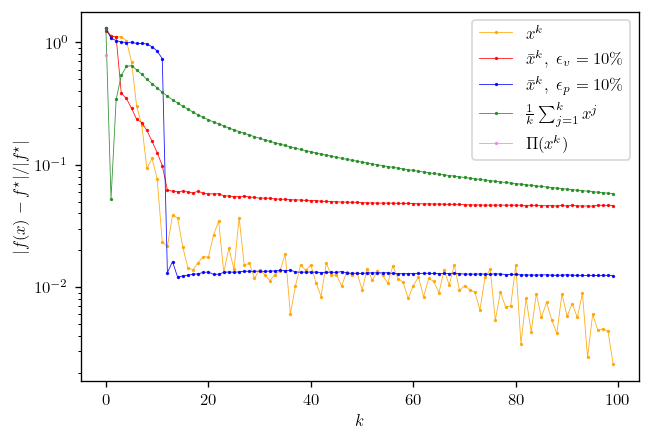

In [13]:
mra.plot_func_subopt_all(all_res, all_results_eps, all_results_noisy_y, true_f, eps_sublevel, percent, 
                        filename=filename, T=100)

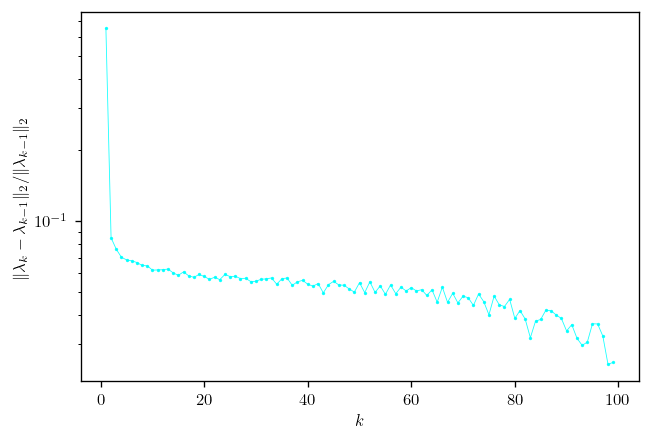

In [14]:
mra.plot_lamb_k_diff(all_res, filename)

In [15]:
print(np.array(all_res["viol_primal_xk"])[-1],
      "sub_eps", np.array(all_results_eps["viol_primal_mra_xk"])[-1],
      "noisy_y", np.array(all_results_noisy_y["viol_primal_mra_xk"])[-1])

27.811410063051326 sub_eps 0.0 noisy_y 0.0


In [16]:
print("sub_eps", np.array(all_results_eps["viol_primal_mra_xk"]).size,
      "noisy_y", np.array(all_results_noisy_y["viol_primal_mra_xk"]).size)

sub_eps 100 noisy_y 100


T=100
27.811410063051326 sub_eps 0.0 noisy_y 0.0


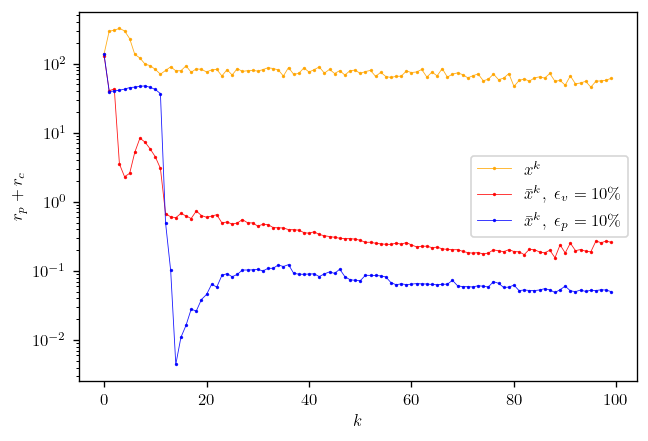

In [17]:
mra.plot_prim_complem_residuals(all_res, all_results_eps, all_results_noisy_y, b_norm, eps_sublevel, percent, 
                               filename=filename, T=100)

T=100
27.811410063051326 sub_eps 0.0 noisy_y 0.0


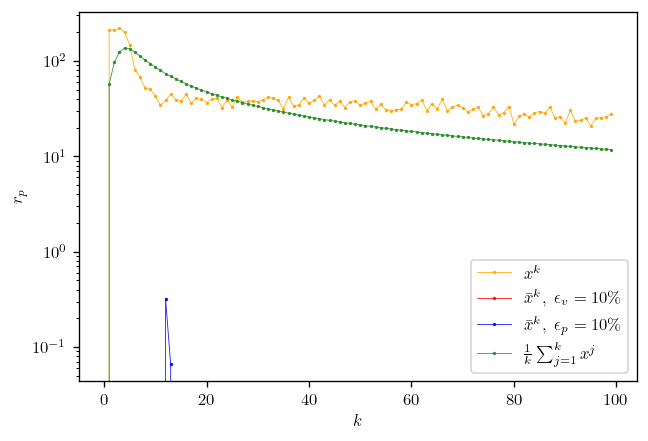

In [18]:
mra.plot_prim_residuals(all_res, all_results_eps, all_results_noisy_y, b_norm, eps_sublevel, percent, 
                       filename=filename, T=100)

T=100


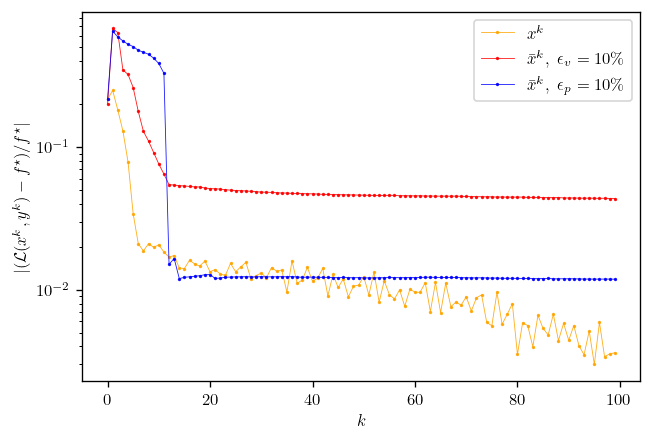

In [19]:
mra.plot_lagr_subopt_all(all_res, all_results_eps, all_results_noisy_y, eps_sublevel, percent, true_f=true_f,
                        filename=filename, T=100)

In [20]:
T = 100
idx_xk = np.argmin(np.array(all_res["viol_primal_xk"])[:T])
idx_paverage = np.argmin(np.array(all_res["viol_primal_paver_xk"])[:T])
idx_noisy_y = np.where(np.array(all_results_noisy_y["viol_primal_mra_xk"][:T]) < 1e-8)[0][0]
idx_eps = np.where(np.array(all_results_eps["viol_primal_mra_xk"][:T]) < 1e-8)[0][0]

print(f"{idx_xk=}, {idx_eps=}, {idx_noisy_y=}, {idx_paverage=}")

print("xk", (np.abs(np.array(all_res["f_xk"]) - true_f)/np.abs(true_f))[idx_xk],
    "sub_eps", (np.abs(np.array(all_results_eps["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_eps],
    "noisy_y", (np.abs(np.array(all_results_noisy_y["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_noisy_y],
    "proj", ((np.abs(np.array(all_res["f_proj_xk"]) - true_f))/np.abs(true_f)).min(),
    "paverage", (np.abs(np.array(all_res["f_paver_xk"]) - true_f)/np.abs(true_f))[idx_paverage])

print("xk", np.array(all_res["viol_primal_xk"])[idx_xk],
      "sub_eps", all_results_eps["viol_primal_mra_xk"][idx_eps],
      "noisy_y", all_results_noisy_y["viol_primal_mra_xk"][idx_noisy_y],
      "paverage", np.array(all_res["viol_primal_paver_xk"])[idx_paverage])

idx_xk=0, idx_eps=0, idx_noisy_y=0, idx_paverage=0
xk 1.3025671292269552 sub_eps 1.246447896915903 noisy_y 1.302567118365459 proj 0.7852904988381181 paverage 1.3025671292269552
xk 0.0 sub_eps 0.0 noisy_y 0.0 paverage 0.0


In [21]:
import pickle

with open(f"../results/{filename}_dict.pkl", "wb") as file:
    pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)
with open(f"../results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)
# res["eps"].keys()

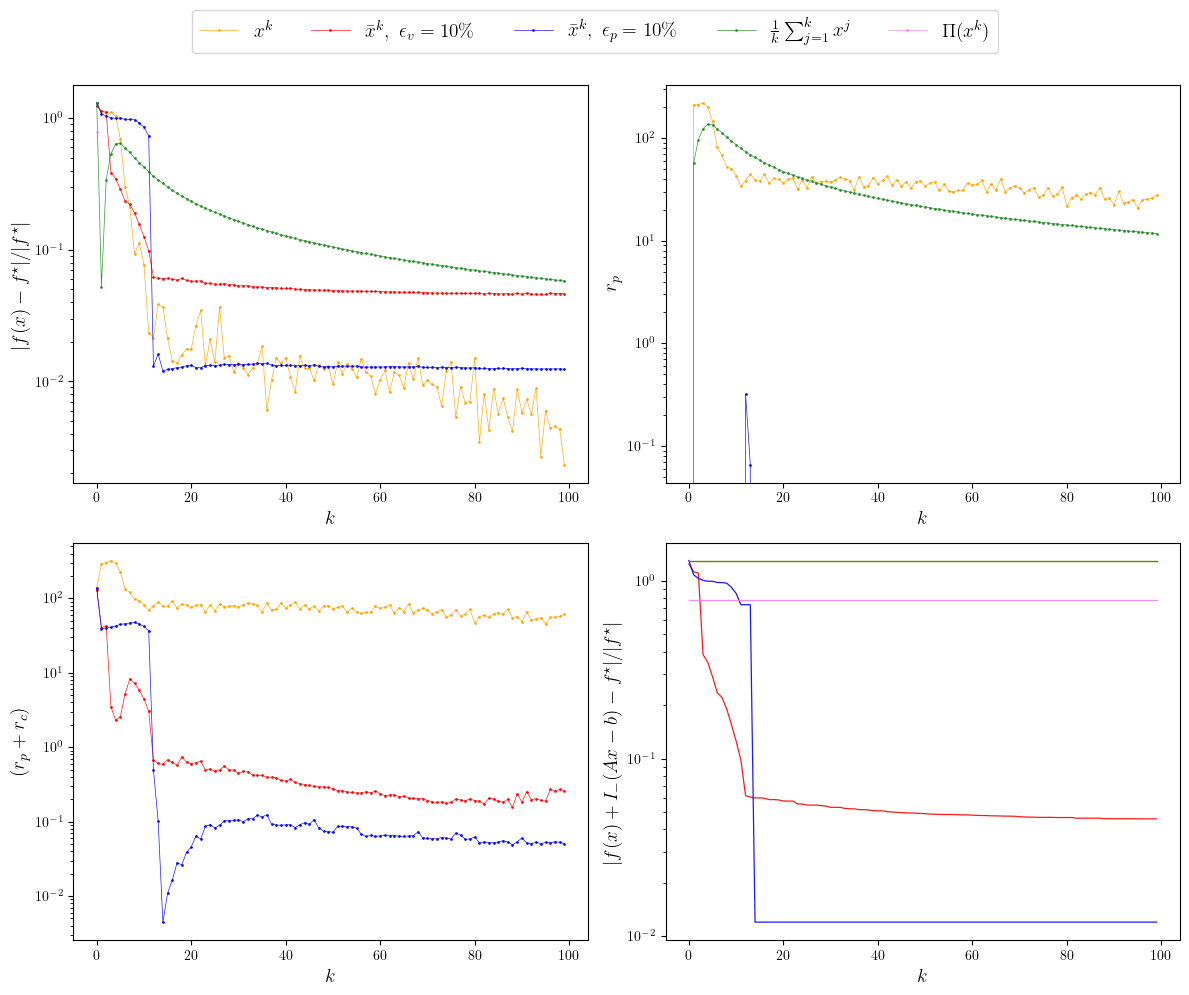

In [22]:
mra.plot_all_methods_metrics_4x(all_results_eps, all_results_noisy_y, true_f, 
                                b_norm, percent, eps_sublevel, filename, T)